In [1]:
import numpy as np

from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute

In [2]:
J = np.zeros((3, 3))
J[0][1] = 0.1385
J[1][2] = 0.01304
J[0][2] = 0.00148

CX = np.eye(4)
CX[2][2] = 0
CX[3][3] = 0
CX[2][3] = 1
CX[3][2] = 1

SWAP = np.eye(4)
SWAP[1][1] = 0
SWAP[2][2] = 0
SWAP[1][2] = 1
SWAP[2][1] = 1

TOFFOLI = np.eye(8)
TOFFOLI[6][6] = 0
TOFFOLI[7][7] = 0
TOFFOLI[6][7] = 1
TOFFOLI[7][6] = 1

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self.__Id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self.__X + math.sin(self.params[1]) * self.__Y)


distance: 0.106687 ; time: -2.15


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(


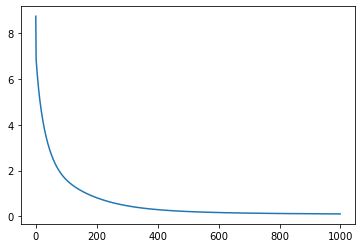

In [3]:
n = 1
m = 1000
k = 4

evolutions = [Evolution(CX, k) for _ in range(n)]

for evolution in evolutions:
    evolution.noise = 0.05
    evolution.randomize_params()
    evolution.set_j(J)

losses = [evolution.descend(steps=m, track_distance=True) for evolution in evolutions]

for loss in losses:
    plt.plot(np.real(loss))
for i in range(n):
    print("distance:", evolutions[i].distance.round(6).real, "; time:", evolutions[i].time.round(2))

In [4]:
for i in range(n):
    for j in range(k):
        print(evolutions[i].gates[j].time, end=" ")
    print("\n")

circuit = evolutions[0].to_qiskit()

backend = Aer.get_backend('unitary_simulator')
job = execute(circuit, backend)
result = job.result()
matrix = result.get_unitary(circuit, decimals=2)
print(evolutions[0].matrix.round(2), "\n" ,matrix.round(2))

circuit.draw()

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  circuit.hamiltonian(self.hamiltonian, float(self.time), circuit.qubits)
C:\Users\Panfe\anaconda3\envs\GRAPE\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


(-0.06401805288672013+0j) (0.7870374101959862+0j) (-2.8726775124225834+0j) 0.0 

[[ 0.99-0.12j  0.08-0.02j -0.01-0.01j  0.02-0.06j]
 [-0.08-0.03j  0.99+0.11j  0.07-0.05j -0.  +0.02j]
 [-0.03-0.05j -0.01+0.01j  0.09+0.01j  0.99-0.11j]
 [ 0.02-0.j   -0.06-0.07j  0.99+0.11j -0.09+0.01j]] 
 [[ 0.99-0.12j  0.08-0.02j -0.01-0.01j  0.02-0.06j]
 [-0.08-0.03j  0.99+0.11j  0.07-0.05j -0.  +0.02j]
 [-0.03-0.05j -0.01+0.01j  0.09+0.01j  0.99-0.11j]
 [ 0.02-0.j   -0.06-0.07j  0.99+0.11j -0.09+0.01j]]


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(


global phase: 3.9272
      ┌──────────────────┐┌──────────────┐┌──────────────────┐┌──────────────┐»
q_0: ─┤ R(2.2119,5.2218) ├┤0             ├┤ R(5.4176,5.5796) ├┤0             ├»
     ┌┴──────────────────┤│  Hamiltonian │├──────────────────┤│  Hamiltonian │»
q_1: ┤ R(2.3644,0.66468) ├┤1             ├┤ R(5.2926,3.3015) ├┤1             ├»
     └───────────────────┘└──────────────┘└──────────────────┘└──────────────┘»
«     ┌─────────────────┐┌──────────────┐┌──────────────────┐
«q_0: ┤ R(2.8261,1.221) ├┤0             ├┤ R(1.6762,5.0116) ├
«     ├─────────────────┤│  Hamiltonian │├──────────────────┤
«q_1: ┤ R(5.8299,5.519) ├┤1             ├┤ R(3.2727,4.5004) ├
«     └─────────────────┘└──────────────┘└──────────────────┘

In [5]:
A = evolutions[0].matrix
evolutions[0].make_times_positive()
B = evolutions[0].matrix

for i in range(n):
    for j in range(k):
        print(evolutions[i].gates[j].time, end=" ")
    print("\n")

circuit = evolutions[0].to_qiskit()
circuit.draw()

backend = Aer.get_backend('unitary_simulator')
job = execute(circuit, backend)
result = job.result()
matrix = result.get_unitary(circuit, decimals=2)
print(evolutions[0].matrix.round(2), "\n" ,matrix.round(2))

circuit.draw()

(0.06401805288672013-0j) (0.7870374101959862+0j) (2.8726775124225834-0j) 0.0 

[[ 0.31-0.05j -0.13-0.93j -0.07+0.08j  0.02-0.01j]
 [ 0.13-0.93j  0.31+0.05j  0.  -0.01j -0.08+0.09j]
 [ 0.01-0.01j  0.09+0.06j  0.2 +0.93j  0.3 -0.03j]
 [ 0.05+0.11j -0.03-0.02j  0.3 +0.03j -0.19+0.93j]] 
 [[ 0.31-0.05j -0.13-0.93j -0.07+0.08j  0.02-0.01j]
 [ 0.13-0.93j  0.31+0.05j  0.  -0.01j -0.08+0.09j]
 [ 0.01-0.01j  0.09+0.06j  0.2 +0.93j  0.3 -0.03j]
 [ 0.05+0.11j -0.03-0.02j  0.3 +0.03j -0.19+0.93j]]


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  circuit.hamiltonian(self.hamiltonian, float(self.time), circuit.qubits)


global phase: 3.9272
      ┌──────────────────┐┌──────────────┐┌──────────────────┐┌──────────────┐»
q_0: ─┤ R(2.2119,5.2218) ├┤0             ├┤ R(5.4176,5.5796) ├┤0             ├»
     ┌┴──────────────────┤│  Hamiltonian │├──────────────────┤│  Hamiltonian │»
q_1: ┤ R(8.6476,0.66468) ├┤1             ├┤ R(11.576,3.3015) ├┤1             ├»
     └───────────────────┘└──────────────┘└──────────────────┘└──────────────┘»
«     ┌─────────────────┐┌──────────────┐┌──────────────────┐
«q_0: ┤ R(2.8261,1.221) ├┤0             ├┤ R(1.6762,5.0116) ├
«     ├─────────────────┤│  Hamiltonian │├──────────────────┤
«q_1: ┤ R(12.113,5.519) ├┤1             ├┤ R(9.5559,4.5004) ├
«     └─────────────────┘└──────────────┘└──────────────────┘